## Sagnac Frequency - Backscatter Correction - RV Backscatter

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [99]:
config = {}

config['ring'] = "Z"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# since PD for monobeams at RZ
config['tbeg'] = UTCDateTime("2024-07-29 16:00")
config['tend'] = UTCDateTime().now()
flim1, flim2 = 553.569, 553.575

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [100]:
bs = __load_backscatter_data(config['tbeg'], config['tend']+86400, config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_00:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_01:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_02:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_03:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_04:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_05:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_06:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJZ_20240801_07:00:00_

### Compute Backscatter (again)

In [101]:
from functions.backscatter_correction import __backscatter_correction

In [102]:
# unwrap phases as one time series
# bs['fj_ph'] = bs.fj_ph
# bs['f1_ph'] = bs.f1_ph
# bs['f2_ph'] = bs.f2_ph
# ph1 = bs.f1_ph
# ph2 = bs.f2_ph

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)
ph1 = np.unwrap(bs.f1_phw)
ph2 = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'], _, _ = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)
# bs['fj_bs'], _, _ = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.5)


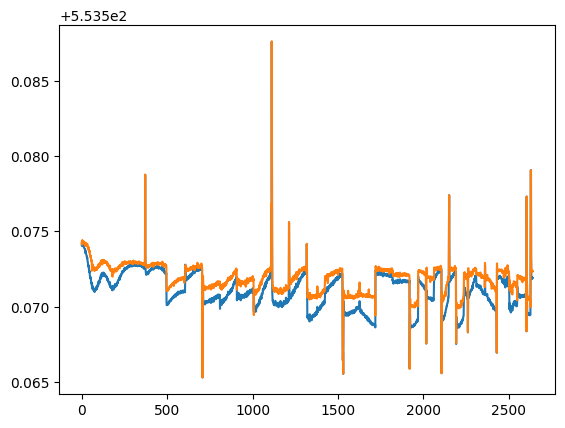

In [103]:
plt.plot(bs.fj_fs)
plt.plot(bs.fj_bs)

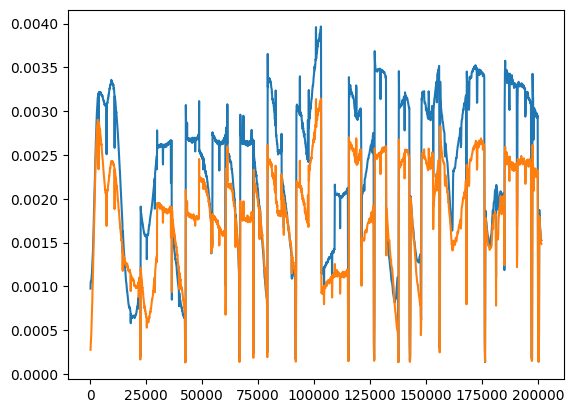

In [104]:
plt.plot(bs.time_sec, bs.f2_ac/bs.f2_dc)
plt.plot(bs.time_sec, bs.f1_ac/bs.f1_dc)

### Cut corrupt data periods

In [105]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [106]:
def __time_spans_to_nan(bs, time_spans):

    for t1, t2 in time_spans:
        bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
        bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)

time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
             ]

__time_spans_to_nan(bs, time_spans)

In [107]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

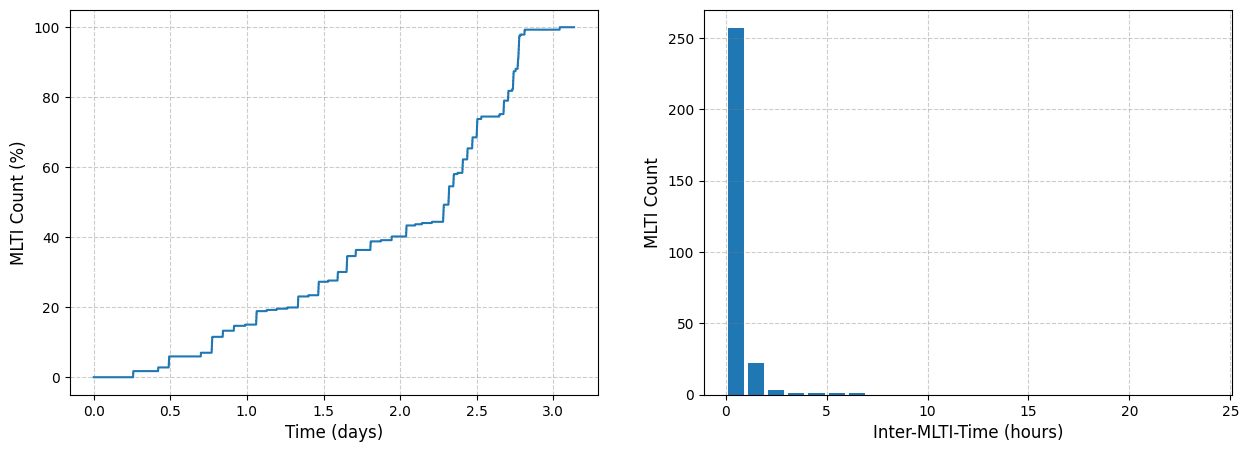

In [108]:
from functions.get_mlti_statistics import __get_mlti_statistics

# arr_mlti, mlti_cumsum, mlti_cumsum_perc, mlti_inter_sec = __get_mlti_statistics(mlti_t1, bs.time1, plot=True, ylog=False)

mlti_stats = __get_mlti_statistics(mlti, config['tbeg'], config['tend'], plot=True, ylog=False)


### Apply special filter sections

In [109]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [110]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [111]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Find phase jumps

In [112]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

/home/brotzer/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:22: RuntimeWarning: Mean of empty slice
  STA = np.nanmean(abs(_data[n-int(ST):n]))
/home/brotzer/notebooks/SagnacFrequency/functions/get_phase_jumps_sta_lta.py:21: RuntimeWarning: Mean of empty slice
  LTA = np.nanmean(abs(_data[n-int(LT):n]))


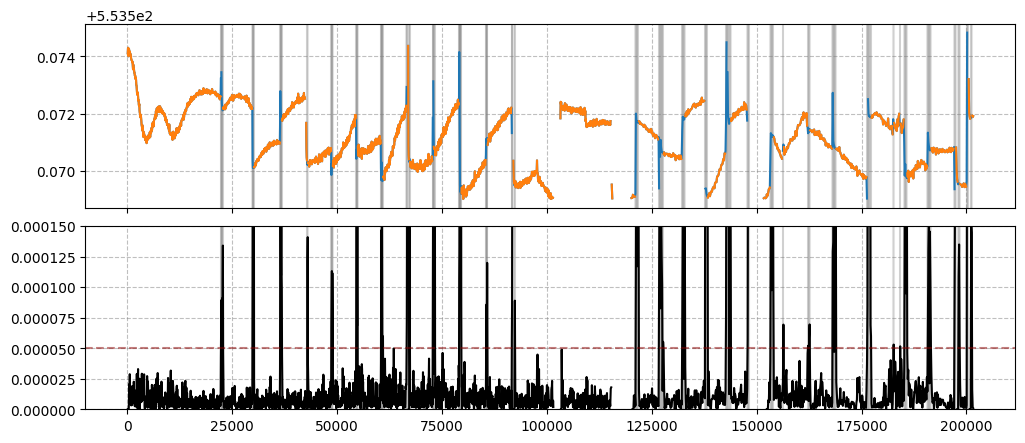

In [113]:
ratio, detect = get_phase_jumps_sta_lta(np.array(bs.fj_fs), np.array(bs.time_sec), 5, 3, amp_threshold=5e-5)


In [114]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

#### Correct phase jumps

In [93]:
def __reduce_phase_jumps(data, detect):

    data = np.array(data)

    di = 5
    offset = 3
    for _i in range(len(data)):

        if detect[_i] == 1:
            left = np.nanmean(data[_i-offset-di:_i-offset])
            right = np.nanmean(data[_i+offset:_i+offset+di])

            diff = left - right

            data[_i-3:_i] = left

            data[_i:] += diff

    return data

In [94]:
bs['fj_fs_dejump'] = __reduce_phase_jumps(bs.fj_fs_inter, detect)
bs['fj_bs_dejump'] = __reduce_phase_jumps(bs.fj_bs_inter, detect)

### Checkup Plot

/tmp/ipykernel_3055050/1830721788.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


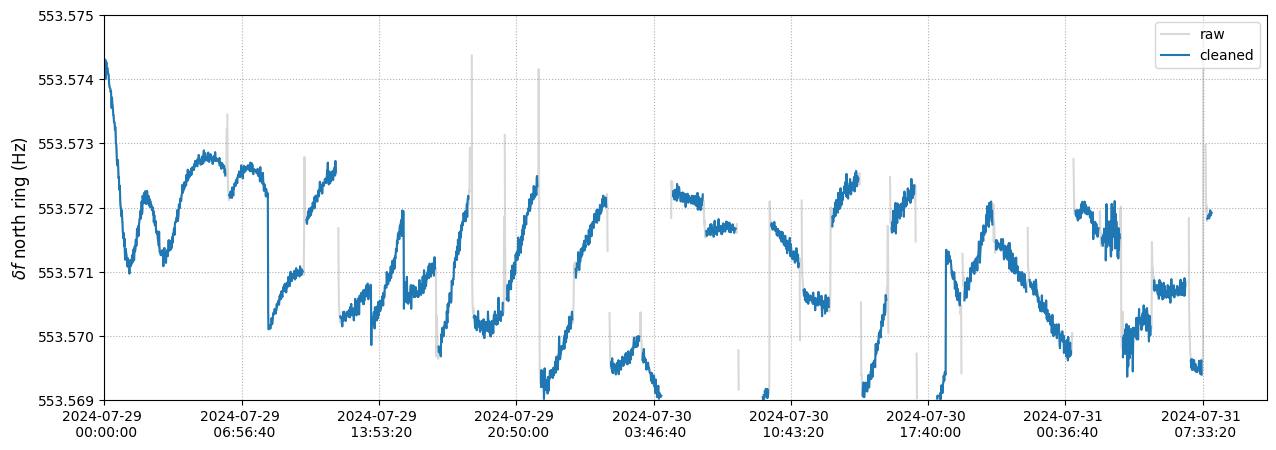

In [95]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


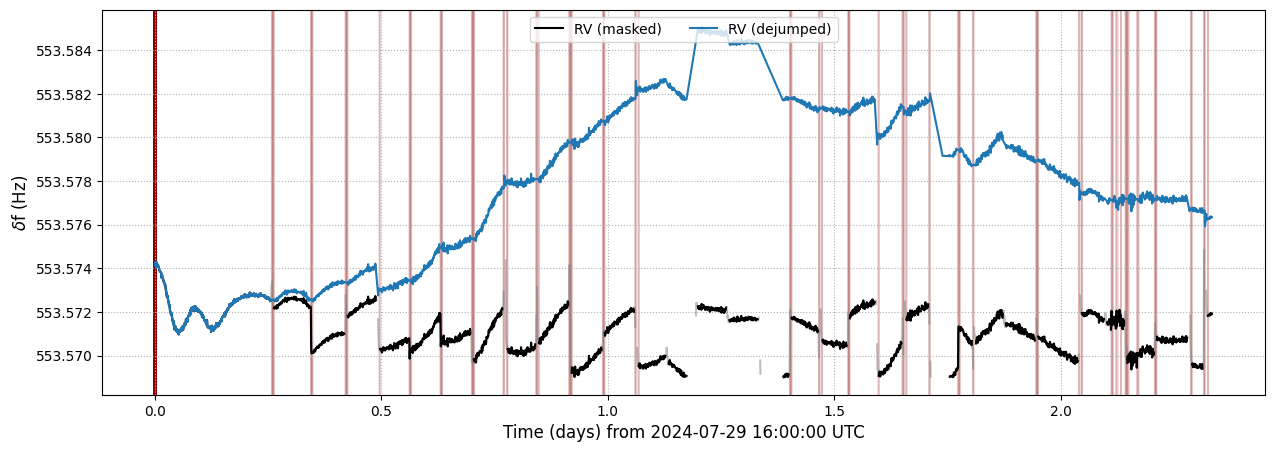

In [96]:
def __makeplot5():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/86400, "days"

    ax.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.5)
    ax.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label="RV (masked)")
    ax.plot(bs.time_sec*tscale, bs.fj_fs_dejump, color="tab:blue", label="RV (dejumped)")

    for d in detect*bs.time_sec*tscale:
        ax.axvline(d, alpha=0.1, zorder=1, color="darkred")

    ax.ticklabel_format(useOffset=False)

    # ax.set_ylim(447.726, 447.738)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=9, ncol=2)

    ax.set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    plt.show();
    return fig

fig = __makeplot5();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_dejump.png", format="png", dpi=150, bbox_inches='tight')


In [97]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

bs['fj_bs_smooth_inter'] = __interpolate_nan(np.array(bs.fj_bs_smooth))

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")
dat3 = detrend(bs.fj_bs_smooth_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60, window="cosine")
psd2, f2, pha2 = __get_fft(dat2, 60, window="cosine")
psd3, f3, pha3 = __get_fft(dat3, 60, window="cosine")
# psd1, f1, pha1 = __get_fft(dat1, 60)
# psd2, f2, pha2 = __get_fft(dat2, 60)
# psd3, f3, pha3 = __get_fft(dat3, 60)

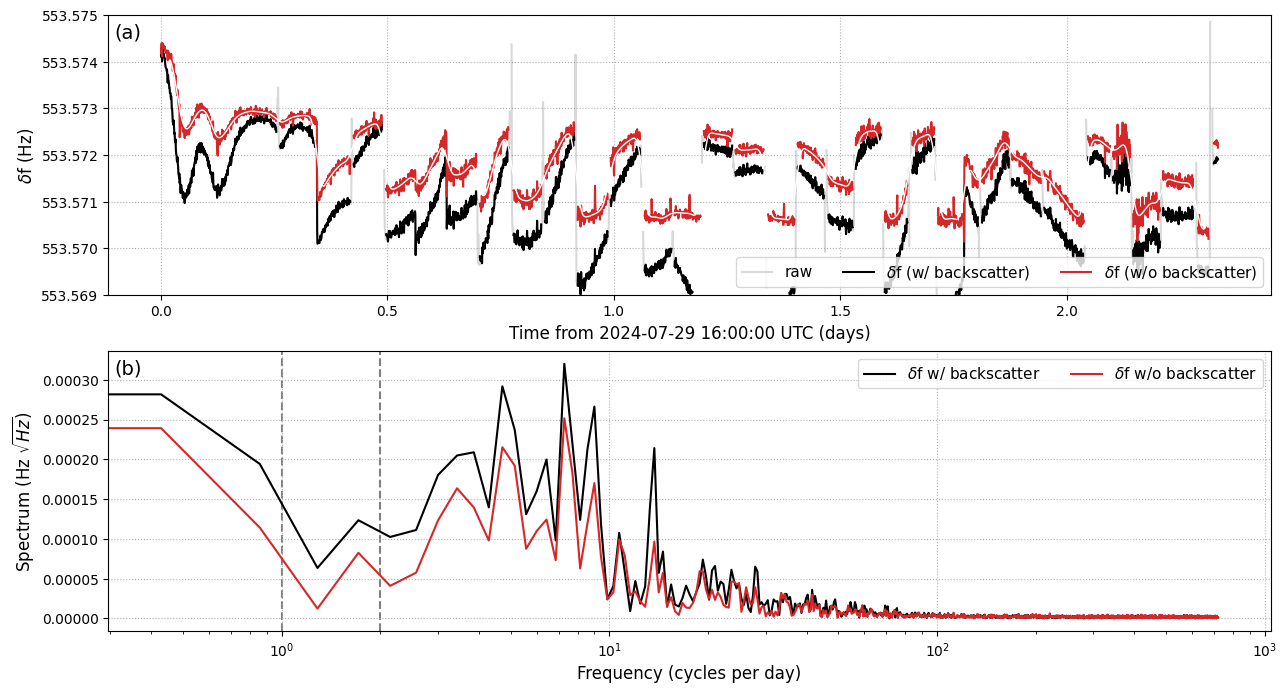

In [98]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1*86400, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2*86400, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")
    # ax[1].semilogx(f3, psd3, color="tab:grey", label=f"$\delta$f w/o backscatter (smooth)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=4, fontsize=font-1, ncol=3)
    ax[1].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (cycles per day)", fontsize=font)

    ax[1].axvline(1/(12*3600)*86400, ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600)*86400, ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


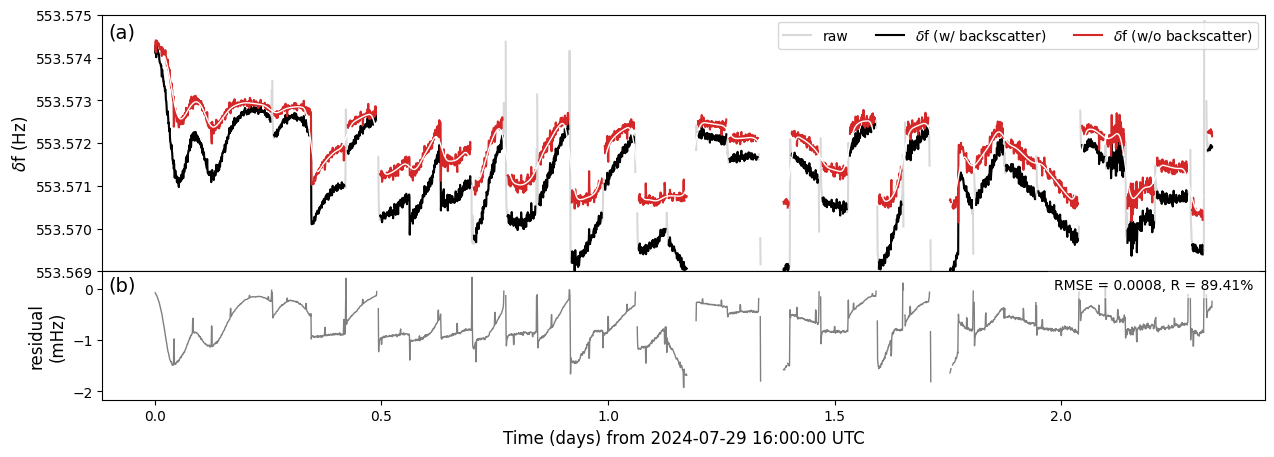

In [61]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .95, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2, bbox=dict(facecolor='white', alpha=0.6, edgecolor="w"))

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


In [62]:
# from andbro__store_as_pickle import __store_as_pickle

# __store_as_pickle(fig, "/home/andbro/notebooks/RomyMonitor/images/fig0.pkl")

## Plot with zoom-in

In [ ]:
# %matplotlib tk

In [ ]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 2, 5

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax1 = fig.add_subplot(gs1[0:2, :])
    ax2 = fig.add_subplot(gs1[2, :])
    ax3 = fig.add_subplot(gs2[3:5, :1])
    ax4 = fig.add_subplot(gs2[3:5, 1:])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    t31, t32 = 2.0, 2.7 # days
    t31, t32 = 12.0, 13.8 # days
    # t31, t32 = 8.0, 9.0 # days
    n31, n32 = int(t31*1440), int(t32*1440)
    print(n31, n32)
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs[n31:n32], color="tab:grey", alpha=0.3, label="raw")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs_nan[n31:n32], color="black", label=f"$\delta$f (w/ backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_nan[n31:n32], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_smooth[n31:n32], color="w", lw=1)
    ax3.set_xlim(t31, t32)

    t41 ,t42 = 18.5, 19.3 # days
    n41, n42 = int(t41*1440), int(t42*1440)
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs[n41:n42], color="tab:grey", alpha=0.3, label="raw")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs_nan[n41:n42], color="black", label=f"$\delta$f (w/ backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_nan[n41:n42], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_smooth[n41:n42], color="w", lw=1)
    ax4.set_xlim(t41, t42)


    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n31]*tscale, bs.time_sec[n32]*tscale,
                      color="purple", alpha=0.1
                     )
    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n41]*tscale, bs.time_sec[n42]*tscale,
                      color="purple", alpha=0.1
                     )

    ax1.set_ylim(flim1, flim2)
    ax3.set_ylim(447.730, 447.735)
    ax4.set_ylim(447.728, 447.735)

    for ax in [ax1, ax3, ax4]:
        ax.ticklabel_format(useOffset=False)
        ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)

    ax1.legend(loc=4, ncol=3)

    ax2.set_ylabel(f"Residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")


    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax3.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax4.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

# fig = __makeplot_residual()

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}_zoomin.png",
#             format="png", dpi=150, bbox_inches='tight')


## Make Stream

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_fs_inter)
dff = np.array(bs.fj_bs_inter)
dff = np.array(bs.fj_bs_dejump)

rx = Trace()
rx.data = dff
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [ ]:
# rx = rx.trim(UTCDateTime("2024-07-05"), UTCDateTime("2024-07-18"))

rx = rx.detrend("linear")
rx = rx.detrend("simple")

rx = rx.taper(0.01, type="cosine")

# rx = rx.filter("bandpass", freqmin=1/(30*3600), freqmax=1/(1*3600), zerophase=True, corners=4)
rx.plot();

In [ ]:
# https://www.engineeringtoolbox.com/linear-expansion-coefficients-d_95.html

In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_inter)

dff_tilt = __sagnac_to_tilt(dff, config['ring'], tilt='n-s')

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [ ]:
fmin, fmax = 1/(14*3600), 1/(10*3600)

rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)

rxx = rxx.resample(5.0)

rxx = rxx.detrend("linear")

rxx = rxx.taper(0.05)

# rxx = rxx.filter("lowpass", freq=fmax, corners=2, zerophase=True)

rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

# rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=True)

rxx

rxx.plot();

In [ ]:
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.read_yaml import __readYaml

In [ ]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 = __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

In [ ]:
tromy = tromy0.copy();

tromy = tromy.merge(fill_value="interpolate");

tromy = tromy.trim(config['tbeg'], config['tend'])
# tromy = tromy.resample(1, no_filter=False)
# tromy = tromy.resample(0.1, no_filter=False)
# tromy = tromy.resample(1/60, no_filter=False)

tromy = tromy.detrend("linear")
tromy = tromy.taper(0.01, type="cosine")
tromy = tromy.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tromy.plot(equal_scale=False);


In [ ]:
plt.plot(tromy.select(channel="*N")[0].times(), tromy.select(channel="*N")[0].data)

plt.plot(rxx.select(channel="*V")[0].times(), 0.4*rxx.select(channel="*V")[0].data)

plt.ylim(-2e-7, 2e-7)